In [1]:
!pip install swig
!pip install gymnasium[box2d]
!pip install git+https://github.com/arnavg115/agrad.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 39.6 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376424 sha256=f77d81792efed5ef536da09f83c15dcb77ef9fa7d0f70a815fca5e2418c2c13a
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Cloning https://github.com/arnavg115/agrad.git to /tmp/pip-req-build-ybmut3vj
  Running command git clone --filter=blob:none --quiet https://github.com/arnavg115/agrad.git /tmp/pip-req-build-ybmut3vj
  Resolved https://github.com/arnavg115/agrad.git to commit 78ea381d020ee9bc6fb1cf2fa4f35a94e812963e
  Preparing metadata (setup.py) ... done
  Created wheel for agrad: filename=agrad-1.0.2-py3-none-any.whl size=8

In [1]:
import gymnasium as gym
import random

In [2]:
import agrad
from agrad import Module, F, Tensor
import agrad.nn as nn
from agrad.nn import MSE
import agrad.nn.optimizer as optim
import numpy as np
from collections import deque

In [3]:
class mlp(Module):
  def __init__(self, obs, action):
    self.l1 = nn.Linear(obs, 64)
    self.l2 = nn.Linear(64, 64)
    self.l3 = nn.Linear(64,action)

  def forward(self, x):
    y = F.relu(self.l1(x))
    y = F.relu(self.l2(y))
    return self.l3(y)

In [4]:
env = gym.make("LunarLander-v3")

In [ ]:
eps = 0.99
decay = 0.995
gamma = 0.99
min_eps = 0.1
lr = 5e-4
batch_size = 64
tau = 1e-3
qn = mlp(env.observation_space.shape[0],env.action_space.n)
moving_rew = deque(maxlen=5)

def get_action(eps, obs):
  n = random.random()
  if n < eps:
    return random.randint(0,env.action_space.n-1)
  out = qn(obs).data
  return int(np.argmax(out))

criterion = MSE()
optimizer = optim.adam(lr = lr)

states = []
next_states = []
actions = []
rewards = []
dones = []
lengs = []
lossesss = []


tot = 0
for ep in range(10000):
  done = False
  obs, _ = env.reset()
  lens = 0
  final_rew = 0
  learned = 0
  avg_loss = 0
  while not done:
    action = get_action(eps, Tensor(obs))
    next_obs, reward, terminated, truncated, info = env.step(action)
    final_rew+=reward
    ds = terminated or truncated

    states.append(obs)
    next_states.append(next_obs)
    rewards.append(reward)
    actions.append(action)
    dones.append(int(ds))

    if len(states) > 1e5:
      states = states[1:]
      next_states = next_states[1:]
      rewards = rewards[1:]
      actions = actions[1:]
      dones = dones[1:]

    if batch_size < len(states) and tot % 4 == 0:
      inds = random.sample(range(len(states)),batch_size)
      b_states = Tensor(np.array([states[i] for i in inds]))
      b_n = Tensor(np.array([next_states[i] for i in inds]))
      b_actions = Tensor(np.array([actions[i] for i in inds])).reshape((-1,1))
      b_rewards = Tensor(np.array([rewards[i] for i in inds])).reshape((-1,1))
      b_dones = Tensor(np.array([dones[i] for i in inds])).reshape((-1,1))
      qpred = qn(b_states)
      qp = agrad.gather(qpred, b_actions.data, 1)
      # qpred = qpred.gather(1, b_actions)

      max_n = qn(b_n).data.max(axis=1)
      max_n = max_n.reshape(-1,1)

      tgt = b_rewards + (-b_dones + 1) * max_n * gamma

      qn.zero_grad()
      # print(qp.data.dtype)
      loss = criterion(qp, tgt, reduction="mean")
      loss.backward()
      optimizer.step(qn)
      learned+=1
      avg_loss+=loss.item()
    lens+=1
    tot+=1
    obs = next_obs
    done = terminated or truncated
  if ep > 5:
    eps = max(min_eps, eps * decay)
  lengs.append(lens)
  moving_rew.append(final_rew)
  if learned > 0:
    lossesss.append(avg_loss/learned)
    print(f"Ep {ep}, avg_loss: {avg_loss/learned}, len: {lens}, eps: {eps}, reward:{final_rew}")
  else:
    print(f"Ep {ep}, len: {lens}, eps: {eps}, reward: {final_rew}")
  if sum(moving_rew)/len(moving_rew) > 200:
    print("Env solved")
    break


Ep 0, len: 61, eps: 0.99, reward: -125.09795165148539
Ep 1, avg_loss: 110.3796613187523, len: 135, eps: 0.99, reward:-403.8942946849495
Ep 2, avg_loss: 213.3009182557643, len: 86, eps: 0.99, reward:-221.0745527839212
Ep 3, avg_loss: 131.70865728589058, len: 80, eps: 0.99, reward:-145.82963123679593
Ep 4, avg_loss: 134.5269985643996, len: 93, eps: 0.99, reward:-282.1687905506948
Ep 5, avg_loss: 182.3074805405384, len: 78, eps: 0.99, reward:-285.343926389505
Ep 6, avg_loss: 195.15094619376683, len: 106, eps: 0.98505, reward:-444.8391155606186
Ep 7, avg_loss: 180.4680180500934, len: 132, eps: 0.98012475, reward:-254.39233768751802
Ep 8, avg_loss: 152.58743566898235, len: 90, eps: 0.97522412625, reward:-113.49522630576612
Ep 9, avg_loss: 136.63544372019868, len: 66, eps: 0.97034800561875, reward:-127.27419390651752
Ep 10, avg_loss: 111.07351846957623, len: 125, eps: 0.9654962655906563, reward:-187.6409272984249
Ep 11, avg_loss: 137.5364559185772, len: 66, eps: 0.960668784262703, reward:-24

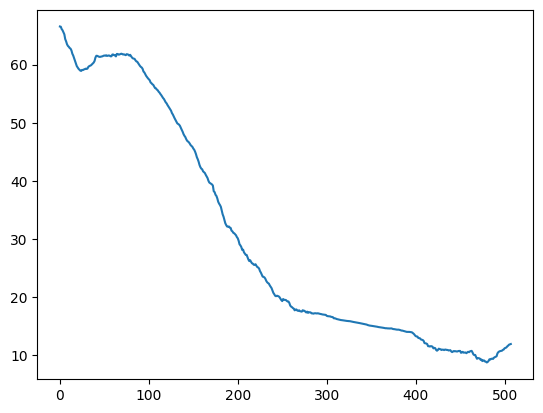

In [8]:
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

window_size = 200

smoothed_data = moving_average(lossesss, window_size)
plt.plot(smoothed_data)


In [11]:


# https://stackoverflow.com/questions/77042526/how-to-record-and-save-video-of-gym-environment
import gymnasium as gym

###
# create a temporary variable with our env, which will use rgb_array as render mode. This mode is supported by the RecordVideo-Wrapper
tmp_env = gym.make("LunarLander-v3", render_mode="rgb_array")

# wrap the env in the record video
tmenv = gym.wrappers.RecordVideo(env=tmp_env,video_folder="/content/new",name_prefix="test-video", episode_trigger=lambda x: x % 1 == 0)

# env reset for a fresh start
obs, info = tmenv.reset()

###
# Start the recorder
# tmenv.start_video_recorder()


# AI logic
for _ in range(1000):
    action = get_action(0, Tensor(obs))

    obs, reward, terminated, truncated, _ = tmenv.step(action)
    tmenv.render()
    if terminated or truncated:
        observation, info = env.reset()

####
# Don't forget to close the video recorder before the env!

# Close the environmentz
tmenv.close()

In [13]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "/content/new/test-video-episode-0.mp4"

# Compressed video path
compressed_path = "/content/new/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)